# 📊 Análise Preditiva do IDH - Projeto Final

# === 1. Importações e configurações iniciais ===

In [ ]:
# Nesta etapa, importamos bibliotecas essenciais para análise de dados, visualização e modelagem preditiva.
import pandas as pd
import numpy as np
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# === 2. Funções auxiliares ===

In [ ]:
# Funções que ajudam na padronização dos nomes das colunas e filtragem de dados específicos.
def normalizar_colunas(df):
    df.columns = df.columns.astype(str)
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(' ', '_')
        .str.replace(r'[\W]+', '', regex=True)
        .map(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', errors='ignore').decode('utf-8'))
    )
    return df

def filtrar_uf_rm(df):
    return df[df['agregacao'].isin(['UF', 'RM_RIDE'])].copy()

# === 3. Leitura e processamento do Atlas Brasil ===

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# Leitura de todas as abas do arquivo Excel do Atlas e seleção da aba 'TOTAL_B', seguida de filtragem para o ano de 2010.
atlas_path = '/content/drive/Othercomputers/Meu computador (1)/2025/Estudo_ProjetoCenso_Portiolio/Atlas_Brasil/ADH_BASE_RADAR_2012-2021.xlsx'
xls = pd.ExcelFile(atlas_path)
atlas_por_aba = {}

for aba in xls.sheet_names:
    df = pd.read_excel(atlas_path, sheet_name=aba)
    df = normalizar_colunas(df)
    df['fonte_aba'] = aba
    atlas_por_aba[aba] = df

df_total_b = atlas_por_aba['TOTAL_B']
df_total_b = filtrar_uf_rm(df_total_b)
df_total_b['ano'] = pd.to_numeric(df_total_b['ano'], errors='coerce')
df_2010 = df_total_b[df_total_b['ano'] == 2010].copy()

# Seleção das colunas de interesse com renomeação para facilitar a interpretação

for aba in xls.sheet_names:
    df = pd.read_excel(atlas_path, sheet_name=aba)
    df = normalizar_colunas(df)
    df['fonte_aba'] = aba
    atlas_por_aba[aba] = df

df_total_b = atlas_por_aba['TOTAL_B']
df_total_b = filtrar_uf_rm(df_total_b)
df_total_b['ano'] = pd.to_numeric(df_total_b['ano'], errors='coerce')
df_2010 = df_total_b[df_total_b['ano'] == 2010].copy()

# Seleção das colunas de interesse com renomeação para facilitar a interpretação
# === 4. Selecionar colunas de interesse ===
df_total_b = df_total_b[[
    'ano', 'nome', 'agregacao', 'codigo',
    'idhm', 'idhm_e', 'idhm_r', 'idhm_l',
    'espvida', 'rdpc', 'fonte_aba'
]].rename(columns={
    'nome': 'municipio',
    'codigo': 'codigo_municipio',
    'idhm_e': 'idhm_educacao',
    'idhm_r': 'idhm_renda',
    'idhm_l': 'idhm_longevidade',
    'espvida': 'expectativa_vida',
    'rdpc': 'renda_per_capita'
})

In [36]:
# === 3. Converter colunas numéricas total_b===
colunas_numericas = [
    'idhm', 'idhm_e', 'idhm_r', 'idhm_l', 'espvida', 'rdpc', 'codigo'
]
for col in colunas_numericas:
    if col in df_total_b.columns:
        df_total_b[col] = pd.to_numeric(df_total_b[col], errors='coerce')

In [37]:
# === 5. Filtrar o ano de 2012 (último consolidado) ===
df_total_b_2012 = df_total_b[df_total_b['ano'] == 2012].copy()

# === 4. Leitura e agregação da base INEP 2010 ===

In [42]:
# verificar e tratar dados faltantes inep_2012

# === 7. Leitura e tratamento da base INEP (anos iniciais) ===
inep_2012_path = '/content/drive/Othercomputers/Meu computador (1)/2025/Estudo_ProjetoCenso_Portiolio/INEP/microdados_censo_escolar_2012/microdados_ed_basica_2012/dados/microdados_ed_basica_2012.csv'
inep_2012 = pd.read_csv(inep_2012_path, sep=';', encoding='latin1', low_memory=False) #Added low_memory=False
inep_2012 = normalizar_colunas(inep_2012)

#Check for missing values
print("\nDados faltantes no INEP 2012 por coluna:")
print(inep_2012.isnull().sum())

#Example of handling missing values (replace with your preferred method)
#1. Drop columns with a high percentage of missing values
threshold = 0.8 # Example: Drop columns with more than 80% missing values
inep_2012 = inep_2012.dropna(thresh=len(inep_2012)*threshold, axis=1)

#2. Fill missing numerical values with the mean
numerical_cols = inep_2012.select_dtypes(include=np.number).columns
inep_2012[numerical_cols] = inep_2012[numerical_cols].fillna(inep_2012[numerical_cols].mean())

#3. Fill missing categorical values with the mode
categorical_cols = inep_2012.select_dtypes(exclude=np.number).columns
inep_2012[categorical_cols] = inep_2012[categorical_cols].fillna(inep_2012[categorical_cols].mode().iloc[0])

colunas_turmas = [col for col in inep_2012.columns if col.startswith('qt_tur_')]
colunas_turmas.append('co_municipio')
inep_turmas = inep_2012[colunas_turmas].copy()

for col in colunas_turmas:
    if col != 'co_municipio':
        inep_turmas[col] = pd.to_numeric(inep_turmas[col], errors='coerce')

inep_2012_agg = inep_turmas.groupby('co_municipio').sum().reset_index()
inep_2012_agg.rename(columns={'co_municipio': 'codigo_municipio'}, inplace=True)
inep_2012_agg['qt_tur_total'] = inep_2012_agg.drop(columns=['codigo_municipio']).sum(axis=1)



Dados faltantes no INEP 2012 por coluna:
nu_ano_censo       0
no_regiao          0
co_regiao          0
no_uf              0
sg_uf              0
                  ..
qt_tur_eja_fund    0
qt_tur_eja_med     0
qt_tur_esp         0
qt_tur_esp_cc      0
qt_tur_esp_ce      0
Length: 370, dtype: int64


# === 5. Merge Atlas + INEP ===

In [45]:
# Unificação das informações sociais e educacionais por município.
df_final = df_total_b_2012.merge(inep_2012_agg[['codigo_municipio', 'qt_tur_total']], on='codigo_municipio', how='left')

# === 6. Segmentação por tipo de município ===

In [47]:
# Criação de uma nova coluna para identificar se o município pertence a uma capital, região metropolitana ou interior.
df_final['grupo_municipio'] = 'Interior'
df_final.loc[df_final['municipio'].str.contains('RM|RIDE', case=False, na=False), 'grupo_municipio'] = 'Regiao_Metropolitana'
df_final.loc[df_final['municipio'].str.contains('CAPITAL', case=False, na=False), 'grupo_municipio'] = 'Capital'

# === 7. Análise exploratória ===

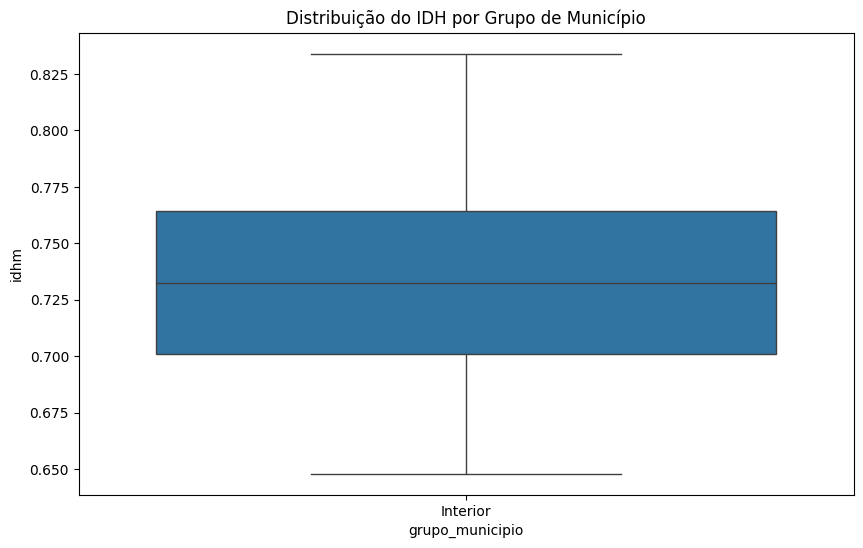

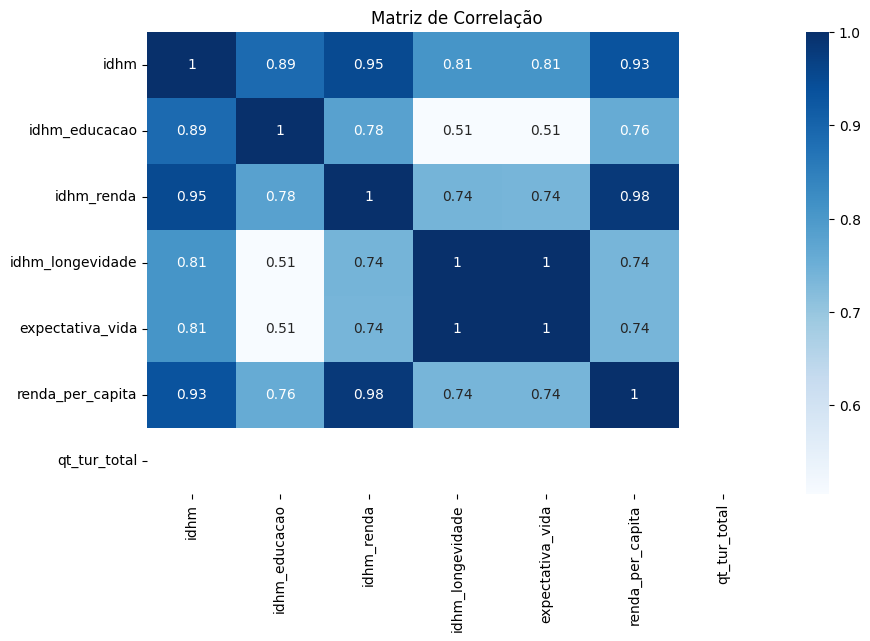

In [49]:
# Visualizações gráficas para entender a distribuição do IDH e a correlação entre variáveis.
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_final, x='grupo_municipio', y='idhm')
plt.title('Distribuição do IDH por Grupo de Município')
plt.show()

plt.figure(figsize=(10, 6))
corr_vars = ['idhm', 'idhm_educacao', 'idhm_renda', 'idhm_longevidade', 'expectativa_vida', 'renda_per_capita', 'qt_tur_total']
sns.heatmap(df_final[corr_vars].corr(), annot=True, cmap='Blues')
plt.title('Matriz de Correlação')
plt.show()

# === 8. Regressão Linear ===

In [52]:
# === 8. Regressão Linear ===
features = ['idhm_educacao', 'idhm_renda', 'idhm_longevidade', 'expectativa_vida', 'renda_per_capita', 'qt_tur_total']
target = 'idhm'

# Select the features and target columns
df_model = df_final[features + [target]].copy()

# Convert columns to numeric, coercing errors to NaN
for col in features + [target]:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

# Impute missing values with the median for numerical columns
# Use fillna(0) as a fallback if the median is NaN (e.g., column is all NaNs)
for col in df_model.columns:
    if df_model[col].isnull().any():
        median_val = df_model[col].median()
        fill_value = median_val if not pd.isna(median_val) else 0
        df_model[col].fillna(fill_value, inplace=True)

# Separate features (X) and target (y) after imputation
X = df_model[features]
y = df_model[target]

# Now proceed with scaling and splitting
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

<ipython-input-52-1711947b5317>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model[col].fillna(fill_value, inplace=True)


LinearRegression()

R²: 0.9998591128742972
MSE: 3.5618519571669565e-07


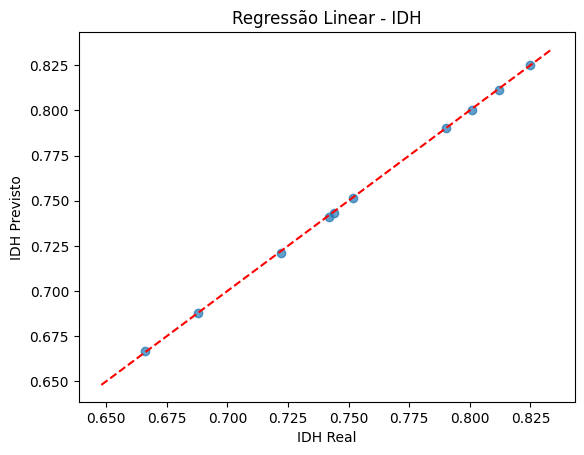

In [54]:
# Avaliação do desempenho do modelo
# R² e MSE são métricas que indicam a qualidade da predição.
y_pred = model.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

# Gráfico Real vs. Previsto
# Verifica se os valores preditos estão próximos da linha ideal (diagonal).
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("IDH Real")
plt.ylabel("IDH Previsto")
plt.title("Regressão Linear - IDH")
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.show()

# === 9. Análise dos resíduos ===

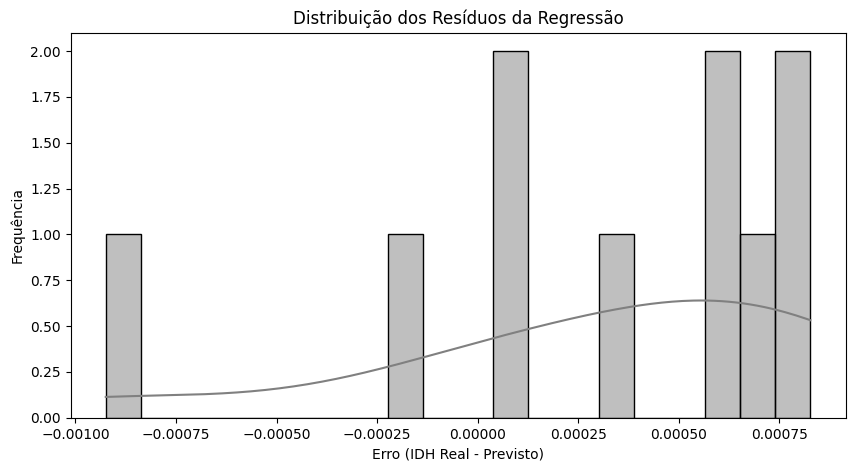

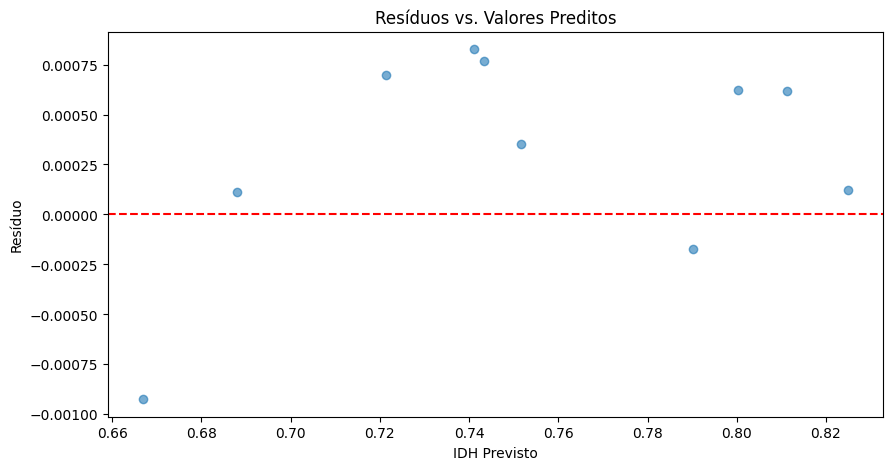

In [55]:
# Análise dos erros do modelo. Idealmente, os resíduos devem se distribuir de forma aproximadamente normal e aleatória.
residuos = y_test - y_pred
plt.figure(figsize=(10, 5))
sns.histplot(residuos, bins=20, kde=True, color='gray')
plt.title('Distribuição dos Resíduos da Regressão')
plt.xlabel('Erro (IDH Real - Previsto)')
plt.ylabel('Frequência')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuos, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('IDH Previsto')
plt.ylabel('Resíduo')
plt.title('Resíduos vs. Valores Preditos')
plt.show()